In [ ]:
# Cell A (data cleaning)
PS_IN  = "/content/ps_usable_hydrogen_storage_capacity_gcmcv2_real_cleaned.csv"
TPS_IN = "/content/tps_usable_hydrogen_storage_capacity_gcmcv2_REAL_cleaned.csv"
REAL_IN= "/content/MOF_database_UTF-8_cleaned_open_source_renamedcolumn.csv"

PS_OUT  = "/content/ps_cleaned_canonical.csv"
TPS_OUT = "/content/tps_cleaned_canonical.csv"
REAL_OUT = "/content/real_cleaned_canonical.csv"

OUT_DIR = "/content/rf_artifacts"
import os, re, textwrap
from pathlib import Path
import numpy as np, pandas as pd
OUT = Path(OUT_DIR); OUT.mkdir(parents=True, exist_ok=True)

CANONICAL = ["Density","PV","GSA","VSA","VF","PLD","LCD"]
NAME_CANDIDATES = ["Name","name","CSD Refcode","CSD_Refcode","csd_refcode","refcode","Refcode","ref_code","id","ID"]

def smart_read(path):
    for enc in ("utf-8-sig","utf-8","latin1","ISO-8859-1"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    raise RuntimeError(f"Cannot read {path} with common encodings")

for p,lbl in [(PS_IN,"PS"),(TPS_IN,"TPS"),(REAL_IN,"REAL")]:
    if not Path(p).exists():
        raise FileNotFoundError(f"Missing input {lbl} at {p} - upload and re-run Cell A")

ps = smart_read(PS_IN); tps = smart_read(TPS_IN); real = smart_read(REAL_IN)

def normalize_cols(df):
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    return df

ps = normalize_cols(ps); tps = normalize_cols(tps); real = normalize_cols(real)

ALIASES = {
    "Density": ["density","rho","framework_density","mass_density"],
    "PV":      ["pv","pore_volume","pore volume","porevolume","p_vol","pvol"],
    "GSA":     ["gsa","gravimetric_surface_area","surface_area_g","sa_g","m2_per_g","m2g","surfacearea_g"],
    "VSA":     ["vsa","volumetric_surface_area","surface_area_v","sa_v","m2_per_cm3","surfacearea_v"],
    "VF":      ["vf","void_fraction","porosity","porosity_fraction"],
    "PLD":     ["pld","pore_limiting_diameter","pore limiting diameter","pore_limit_diameter"],
    "LCD":     ["lcd","largest_cavity_diameter","largest cavity diameter","largest_cavity"]
}

def find_col_by_alias(df, alias_list):
    cols = list(df.columns)
    cols_low = [c.lower() for c in cols]
    for a in alias_list:
        for i,c in enumerate(cols_low):
            if a == c or a in c:
                return cols[i]
    for i,c in enumerate(cols_low):
        toks = re.split(r'[\s_\-]+', c)
        for a in alias_list:
            if a in toks:
                return cols[i]
    return None

def ensure_canonical(df):
    df = df.copy()
    for canon in CANONICAL:
        present = None
        for col in df.columns:
            if col.strip().lower() == canon.lower():
                present = col; break
        if present and present != canon:
            df = df.rename(columns={present: canon})
        elif canon not in df.columns:
            alias_list = ALIASES.get(canon, [canon.lower()])
            found = find_col_by_alias(df, [a.lower() for a in alias_list])
            if found:
                df = df.rename(columns={found: canon})
            else:
                df[canon] = np.nan
    for c in CANONICAL:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

ps = ensure_canonical(ps)
tps = ensure_canonical(tps)
real = ensure_canonical(real)

# Normalize name: strip trailing common tags (e.g. _CoRE, _clean, _neutral, _charged, _manual, _si_001, etc.)
_SUFFIX_RE = re.compile(r'(?i)(?:_s[iI]_\d+|_inc\d+|_clean(ed)?|_core|_CoRE|_neutral|_charged|_manual|_clean|_k\d+|_100K|_11K|_40K|_70K|_si_\d+|_cm\d+|_cleaned)$')

def normalize_name_for_dedupe(name):
    if pd.isna(name):
        return ""
    s = str(name).strip()
    # remove trailing known tags repeatedly (e.g. "DOTSOV42_CoRE_clean" -> remove both)
    prev = None
    while prev != s:
        prev = s
        s = re.sub(_SUFFIX_RE, "", s).rstrip('_- ').strip()
    return s

def extract_base_and_suffix(name):
    # strip trailing tags first (so DOTSOV_CoRE -> DOTSOV ; DOTSOV42_CoRE -> DOTSOV42)
    s = normalize_name_for_dedupe(name)
    if s == "":
        return ("", -1)
    # find numeric suffix at end of the cleaned string
    m = re.search(r'(\d+)$', s)
    if m:
        suffix = int(m.group(1))
        base = s[:m.start()].rstrip('_- ').strip()
        if base == "":
            # if nothing left (name was only digits), keep original cleaned string as base
            base = s
        return (base, suffix)
    else:
        return (s, -1)

def dedupe_keep_highest_numeric(df, name_candidates=NAME_CANDIDATES, subset_by_desc=True, safety_threshold=0.60):
    df2 = df.copy().reset_index(drop=True)
    name_col = None
    for c in name_candidates:
        if c in df2.columns:
            name_col = c; break

    removed_by_name = 0
    removed_by_desc = 0
    kept_example = []
    dropped_example = []
    if name_col:
        parsed = df2[name_col].apply(lambda v: extract_base_and_suffix(v))
        df2["_dup_base"] = parsed.apply(lambda t: t[0])
        df2["_dup_num"]  = parsed.apply(lambda t: t[1])
        dup_counts = df2["_dup_base"].value_counts()
        multi_bases = dup_counts[dup_counts>1].index.tolist()
        if multi_bases:
            sample_base = multi_bases[:6]
            for b in sample_base:
                subset = df2[df2["_dup_base"]==b][[name_col,"_dup_num"]].astype(str)
                kept_example.append((b, subset.to_dict(orient="list")))
        # choose the index with maximum numeric suffix; if all -1 (no digits) will keep first occurrence
        idx_keep = df2.groupby("_dup_base")["_dup_num"].idxmax().values
        mask_keep = df2.index.isin(idx_keep)
        removed_by_name = int((~mask_keep).sum())
        # safety guard
        if removed_by_name / max(1, len(df2)) > safety_threshold:
            print(f"WARNING: name-based dedupe would remove {removed_by_name}/{len(df2)} rows (> {safety_threshold*100:.0f}%). Skipping name-based dedupe.")
            df2 = df2.drop(columns=["_dup_base","_dup_num"])
            removed_by_name = 0
        else:
            dropped_example = df2.loc[~mask_keep, name_col].astype(str).head(10).tolist()
            df2 = df2.loc[mask_keep].drop(columns=["_dup_base","_dup_num"]).reset_index(drop=True)

    # descriptor-level dedupe (drop exact duplicates on canonical descriptors)
    if subset_by_desc:
        before_desc = len(df2)
        subset = [c for c in CANONICAL if c in df2.columns]
        if subset:
            df2 = df2.drop_duplicates(subset=subset).reset_index(drop=True)
            removed_by_desc = before_desc - len(df2)

    return df2.reset_index(drop=True), int(removed_by_name), int(removed_by_desc), kept_example, dropped_example

def drop_missing_desc(df):
    before = len(df)
    subset = [c for c in CANONICAL if c in df.columns]
    if not subset:
        return df, 0
    df2 = df.dropna(subset=subset).reset_index(drop=True)
    return df2, before - len(df2)

def apply_cleaning(df, label):
    before = len(df)
    candidate_name = None
    for c in NAME_CANDIDATES:
        if c in df.columns:
            candidate_name = c; break
    sample_names = df[candidate_name].dropna().astype(str).head(12).tolist() if candidate_name else []
    df_dedup, rem_name, rem_desc, kept_example, dropped_example = dedupe_keep_highest_numeric(df, name_candidates=NAME_CANDIDATES, subset_by_desc=True, safety_threshold=0.60)
    df_clean, rem_missing = drop_missing_desc(df_dedup)
    after = len(df_clean)
    print(textwrap.dedent(f"""
    --- {label} cleaning summary ---
      rows_before: {before}
      sample name column values (first 12) -> {sample_names if sample_names else 'no name-like column found'}
      removed_by_name_dedupe: {rem_name}
      removed_by_desc_dedupe: {rem_desc}
      removed_by_missing_desc (NaN in canonical): {rem_missing}
      rows_after: {after}
    """))
    if kept_example:
        print(" Example duplicate groups (kept highest suffix):")
        for b, info in kept_example:
            print(f"  base='{b}' -> entries: {info}")
    if dropped_example:
        print(" Example dropped names (some older suffixes):", dropped_example)
    if after == 0:
        safe_path = Path(OUT)/f"{label}_diagnostic_post_dedupe.csv"
        df_dedup.to_csv(safe_path, index=False)
        print(f" WARNING: {label} ended with 0 rows after cleaning. Intermediate dedup saved to {safe_path}")
    return df_clean

ps_clean = apply_cleaning(ps, "PS")
tps_clean = apply_cleaning(tps, "TPS")
real_clean = apply_cleaning(real, "REAL")

ps_clean.to_csv(PS_OUT, index=False)
tps_clean.to_csv(TPS_OUT, index=False)
real_clean.to_csv(REAL_OUT, index=False)

print("CELL A complete — cleaned files saved.")
print(f" PS -> {PS_OUT}  rows_before:{len(ps)}  rows_after:{len(ps_clean)}")
print(f" TPS -> {TPS_OUT} rows_before:{len(tps)}  rows_after:{len(tps_clean)}")
print(f" REAL -> {REAL_OUT} rows_before:{len(real)}  rows_after:{len(real_clean)}")
print("If rows_after==0 for any file, open the *_diagnostic_post_dedupe.csv in /content/rf_artifacts to inspect intermediate dedupe.")



--- PS cleaning summary ---
  rows_before: 5041
  sample name column values (first 12) -> ['ECOLEP_CoRE', 'VUSJUP_CoRE', 'GAQYIH_CoRE', 'XUKYEI_CoRE', 'VEBHUG_CoRE', 'BAZFUF_CoRE', 'HABQUY_CoRE', 'GAGZEV_CoRE', 'ZELROZ_CoRE', 'XAFFIV_CoRE', 'VAGMAT_CoRE', 'XAFFAN_CoRE']
  removed_by_name_dedupe: 428
  removed_by_desc_dedupe: 0
  removed_by_missing_desc (NaN in canonical): 0
  rows_after: 4613

 Example duplicate groups (kept highest suffix):
  base='DOTSOV' -> entries: {'Name': ['DOTSOV_CoRE', 'DOTSOV11_CoRE', 'DOTSOV20_CoRE', 'DOTSOV04_CoRE', 'DOTSOV15_CoRE', 'DOTSOV14_CoRE', 'DOTSOV12_CoRE', 'DOTSOV13_CoRE', 'DOTSOV27_CoRE', 'DOTSOV07_CoRE', 'DOTSOV26_CoRE', 'DOTSOV37_CoRE', 'DOTSOV01_CoRE', 'DOTSOV05_CoRE', 'DOTSOV06_CoRE', 'DOTSOV38_CoRE', 'DOTSOV19_CoRE', 'DOTSOV25_CoRE', 'DOTSOV16_CoRE', 'DOTSOV02_CoRE', 'DOTSOV09_CoRE', 'DOTSOV31_CoRE', 'DOTSOV24_CoRE', 'DOTSOV36_CoRE', 'DOTSOV08_CoRE', 'DOTSOV30_CoRE', 'DOTSOV34_CoRE', 'DOTSOV41_CoRE', 'DOTSOV22_CoRE', 'DOTSOV23_CoRE', 'DOTSOV

Detected targets:
 PS: {'PS_UG': 'UG at PS', 'PS_UV': 'UV at PS'}
 TPS: {'TPS_UG': 'UG at TPS', 'TPS_UV': 'UV at TPS'}

Task: PS_UG   (target column: 'UG at PS')
 Labeled rows after dropna: 4613
 Train/test: 3459 / 1154
 Saved metrics: /content/rf_artifacts/metrics_PS_UG_ERT.csv

 ExtraTrees regression metrics:
 R² = 0.9863   RMSE = 0.1663   MAE = 0.1088   MedianAE = 0.0754
 Kendall's τ = 0.8270

 Classification diagnostics (threshold from TRAIN):
 Threshold (train top 10%): 1.96
 Accuracy = 0.9835   Precision = 0.9357   Recall = 0.9291   F1 = 0.9324
 Precision@3 = 1.0   Precision@5 = 1.0   Precision@10 = 1.0   Precision@50 = 0.94
 Best params (RandomizedSearchCV): {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 32, 'bootstrap': False}


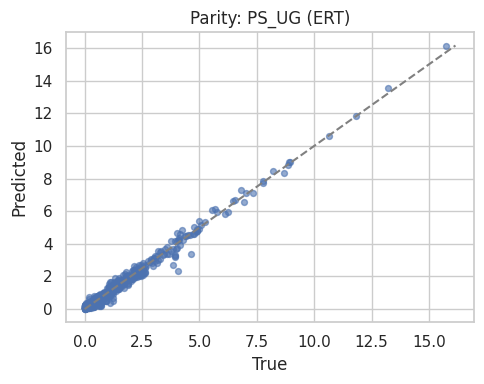

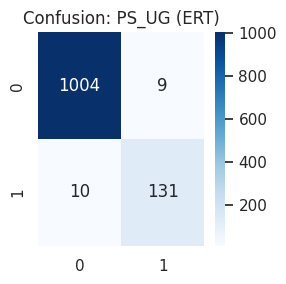

 Saved SHAP: /content/rf_artifacts/shap_PS_UG_ERT.png
 Saved PDP: /content/rf_artifacts/pdp_PS_UG_ERT_top3.png
 Saved final retrained ERT model: /content/rf_artifacts/final_ert_PS_UG.joblib

Task: PS_UV   (target column: 'UV at PS')
 Labeled rows after dropna: 4613
 Train/test: 3459 / 1154
 Saved metrics: /content/rf_artifacts/metrics_PS_UV_ERT.csv

 ExtraTrees regression metrics:
 R² = 0.9331   RMSE = 1.9836   MAE = 1.3964   MedianAE = 1.0107
 Kendall's τ = 0.7778

 Classification diagnostics (threshold from TRAIN):
 Threshold (train top 10%): 18.932
 Accuracy = 0.9844   Precision = 0.9466   Recall = 0.9185   F1 = 0.9323
 Precision@3 = 0.0   Precision@5 = 0.4   Precision@10 = 0.9   Precision@50 = 0.78
 Best params (RandomizedSearchCV): {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 32, 'bootstrap': False}


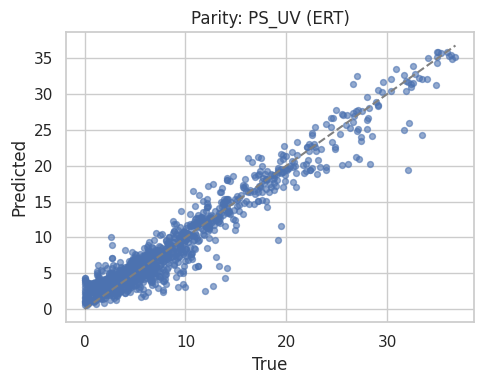

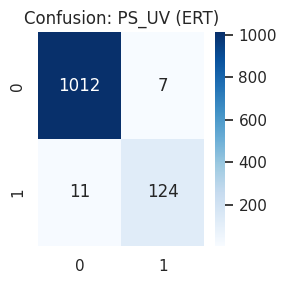

 Saved SHAP: /content/rf_artifacts/shap_PS_UV_ERT.png
 Saved PDP: /content/rf_artifacts/pdp_PS_UV_ERT_top3.png
 Saved final retrained ERT model: /content/rf_artifacts/final_ert_PS_UV.joblib

Task: TPS_UG   (target column: 'UG at TPS')
 Labeled rows after dropna: 4613
 Train/test: 3459 / 1154
 Saved metrics: /content/rf_artifacts/metrics_TPS_UG_ERT.csv

 ExtraTrees regression metrics:
 R² = 0.9905   RMSE = 0.2095   MAE = 0.1461   MedianAE = 0.1067
 Kendall's τ = 0.9067

 Classification diagnostics (threshold from TRAIN):
 Threshold (train top 10%): 4.934
 Accuracy = 0.9922   Precision = 0.9766   Recall = 0.9542   F1 = 0.9653
 Precision@3 = 1.0   Precision@5 = 1.0   Precision@10 = 0.9   Precision@50 = 0.96
 Best params (RandomizedSearchCV): {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 32, 'bootstrap': False}


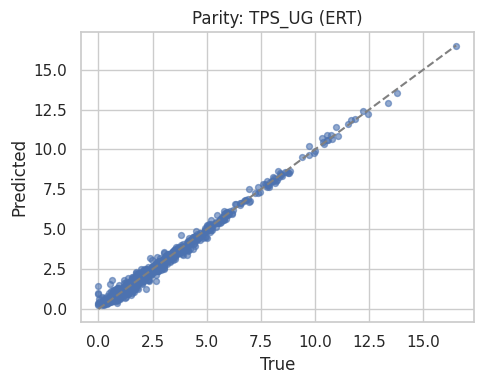

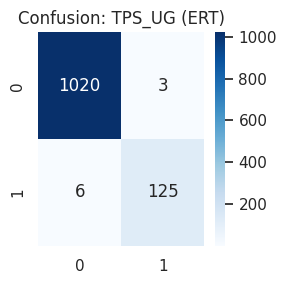

 Saved SHAP: /content/rf_artifacts/shap_TPS_UG_ERT.png
 Saved PDP: /content/rf_artifacts/pdp_TPS_UG_ERT_top3.png
 Saved final retrained ERT model: /content/rf_artifacts/final_ert_TPS_UG.joblib

Task: TPS_UV   (target column: 'UV at TPS')
 Labeled rows after dropna: 4613
 Train/test: 3459 / 1154
 Saved metrics: /content/rf_artifacts/metrics_TPS_UV_ERT.csv

 ExtraTrees regression metrics:
 R² = 0.9315   RMSE = 3.2238   MAE = 2.1626   MedianAE = 1.3976
 Kendall's τ = 0.8495

 Classification diagnostics (threshold from TRAIN):
 Threshold (train top 10%): 44.412
 Accuracy = 0.9818   Precision = 0.9672   Recall = 0.8741   F1 = 0.9183
 Precision@3 = 0.0   Precision@5 = 0.4   Precision@10 = 0.6   Precision@50 = 0.82
 Best params (RandomizedSearchCV): {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 32, 'bootstrap': False}


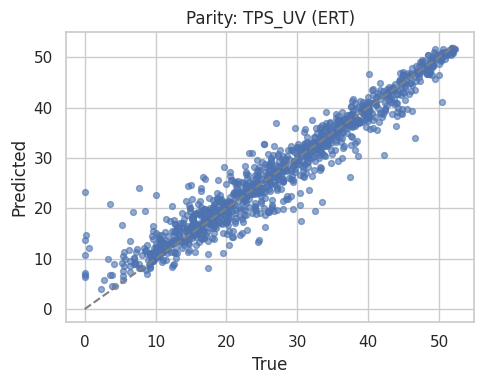

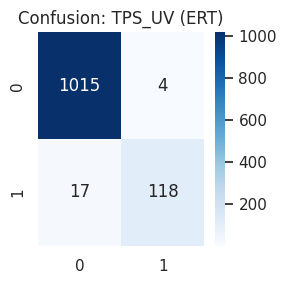

 Saved SHAP: /content/rf_artifacts/shap_TPS_UV_ERT.png
 Saved PDP: /content/rf_artifacts/pdp_TPS_UV_ERT_top3.png
 Saved final retrained ERT model: /content/rf_artifacts/final_ert_TPS_UV.joblib

Aggregated per-target ERT metrics saved to /content/rf_artifacts/aggregated_metrics_summary_ert.csv
 Saved ranking: /content/rf_artifacts/ranking_ML_Predicted_PS_UG_ERT.csv
 Saved ranking: /content/rf_artifacts/ranking_ML_Predicted_PS_UV_ERT.csv
 Saved ranking: /content/rf_artifacts/ranking_ML_Predicted_TPS_UG_ERT.csv
 Saved ranking: /content/rf_artifacts/ranking_ML_Predicted_TPS_UV_ERT.csv
 Saved /content/REAL_with_MLpredictions_ERT.csv
 Saved final combined ranking to /content/rf_artifacts/final_combined_ranking_ERT.csv

Rows total: 12986; rows with >=1 prediction: 12986; in-domain: N/A; OOD: N/A

Top 20 MOFs by composite ERT rank:
                 Name  overall_rank  mean_norm_rank  ML_Predicted_PS_UG_ERT  ML_Predicted_PS_UV_ERT  ML_Predicted_TPS_UG_ERT  ML_Predicted_TPS_UV_ERT
          VAGM

In [ ]:
# Cell B: ERT
RANDOM_STATE = 42
N_ITER_SEARCH = 12       # increase (e.g., 50) if you want more tuning
CV_FOLDS = 10
TEST_SIZE = 0.25
HIGH_PERF_PERCENTILE = 90
OUT_DIR = "/content/rf_artifacts"
USE_IDEAL_FEATURES = False
SAVE_TOPK = 200
N_JOBS = -1

import os, json, warnings
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, confusion_matrix
from scipy.stats import kendalltau
from sklearn.inspection import PartialDependenceDisplay
import joblib
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

OUT = Path(OUT_DIR); OUT.mkdir(parents=True, exist_ok=True)

# Input cleaned files (must exist)
PS_CLEAN  = Path("/content/ps_cleaned_canonical.csv")
TPS_CLEAN = Path("/content/tps_cleaned_canonical.csv")
REAL_CLEAN= Path("/content/real_cleaned_canonical.csv")
for p in [PS_CLEAN, TPS_CLEAN, REAL_CLEAN]:
    if not p.exists():
        raise FileNotFoundError(f"Required cleaned file missing: {p}. Run Cell A and re-run this cell.")

ps = pd.read_csv(PS_CLEAN)
tps = pd.read_csv(TPS_CLEAN)
real = pd.read_csv(REAL_CLEAN)

CANONICAL = ["Density","PV","GSA","VSA","VF","PLD","LCD"]
for df,name in [(ps,"PS"),(tps,"TPS"),(real,"REAL")]:
    missing = [c for c in CANONICAL if c not in df.columns]
    if missing:
        raise KeyError(f"{name} cleaned file missing canonical descriptors: {missing}")

# target detection (robust)
def detect_targets(df, prefix):
    cols = list(df.columns); cols_low = [c.lower() for c in cols]
    found = {}
    ug_alias = ["ug","usable_grav","usable_gravimetric","usable_g","gravimetric","wt%","g_h2_g","usable_hydrogen_gravimetric","ug at"]
    uv_alias = ["uv","usable_vol","usable_volumetric","usable_v","volumetric","g_h2_l","usable_hydrogen_volumetric","uv at"]
    for a in ug_alias:
        for i,c in enumerate(cols_low):
            if a in c:
                found[f"{prefix}_UG"] = cols[i]; break
        if f"{prefix}_UG" in found: break
    for a in uv_alias:
        for i,c in enumerate(cols_low):
            if a in c:
                found[f"{prefix}_UV"] = cols[i]; break
        if f"{prefix}_UV" in found: break
    return found

ps_targets = detect_targets(ps, "PS")
tps_targets = detect_targets(tps, "TPS")
print("Detected targets:")
print(" PS:", ps_targets)
print(" TPS:", tps_targets)

tasks = {}
tasks.update(ps_targets); tasks.update(tps_targets)
if not tasks:
    raise RuntimeError("No labeled targets detected in PS/TPS cleaned files. Confirm target columns and re-run Cell A.")

# features
if USE_IDEAL_FEATURES:
    extra = [f"{c}_dist_to_ideal" for c in CANONICAL] + ["meets_ideal_count","distance_score"]
    FEATURE_COLS = CANONICAL + extra
else:
    FEATURE_COLS = CANONICAL.copy()

# ExtraTrees param distribution
param_dist = {
    "n_estimators": [100, 200, 400, 800],
    "max_depth": [None, 8, 16, 32],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.5, None],
    "bootstrap": [False, True]
}
cv_inner = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# helpers
def reg_metrics(y_true, y_pred):
    r2 = float(r2_score(y_true, y_pred))
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    medae = float(median_absolute_error(y_true, y_pred))
    try:
        kt = float(kendalltau(y_true, y_pred).correlation)
    except Exception:
        kt = None
    return {"r2": r2, "rmse": rmse, "mae": mae, "medae": medae, "kendall_tau": kt}

def class_metrics_from_threshold(y_true, y_pred, threshold):
    y_true_bin = (y_true >= threshold).astype(int)
    y_pred_bin = (y_pred >= threshold).astype(int)
    try:
        cm = confusion_matrix(y_true_bin, y_pred_bin)
    except Exception:
        cm = np.array([[0,0],[0,0]])
    if cm.size == 1:
        cm = np.array([[cm[0],0],[0,0]])
    tn = int(cm[0,0]); fp = int(cm[0,1]); fn = int(cm[1,0]); tp = int(cm[1,1])
    acc = (tn+tp)/(tn+tp+fp+fn) if (tn+tp+fp+fn)>0 else None
    prec = tp/(tp+fp) if (tp+fp)>0 else None
    rec = tp/(tp+fn) if (tp+fn)>0 else None
    f1 = (2*prec*rec/(prec+rec)) if (prec and rec and (prec+rec)>0) else None
    return {"confusion_tn": tn, "confusion_fp": fp, "confusion_fn": fn, "confusion_tp": tp,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

def precision_at_k(y_true, y_pred, k):
    n = len(y_true)
    if n==0: return None
    k = min(k, n)
    topk_pred = set(np.argsort(-np.array(y_pred))[:k])
    topk_true = set(np.argsort(-np.array(y_true))[:k])
    return float(len(topk_pred & topk_true)) / float(k)

results = {}
summary_rows = []
skipped_models = []

for task_key, target_col in tasks.items():
    print("\n" + "="*88)
    print(f"Task: {task_key}   (target column: '{target_col}')")
    src = ps if task_key.startswith("PS") else tps
    dfw = src.dropna(subset=FEATURE_COLS + [target_col]).reset_index(drop=True)
    nrows = len(dfw)
    print(f" Labeled rows after dropna: {nrows}")
    if nrows < 10:
        msg = f"SKIP {task_key}: too few labeled rows ({nrows})"
        print(msg); skipped_models.append(msg); summary_rows.append({"task": task_key, "status":"skipped","reason": msg})
        continue

    X = dfw[FEATURE_COLS].values
    y = pd.to_numeric(dfw[target_col], errors="coerce").values
    mask = ~np.isnan(y)
    X = X[mask]; y = y[mask]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True)
    print(f" Train/test: {len(X_train)} / {len(X_test)}")

    base = ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS)
    rs = RandomizedSearchCV(base, param_distributions=param_dist, n_iter=N_ITER_SEARCH, cv=cv_inner,
                            scoring="r2", n_jobs=N_JOBS, random_state=RANDOM_STATE, verbose=0)
    rs.fit(X_train, y_train)
    best = rs.best_estimator_
    best_params = rs.best_params_

    # evaluate
    y_pred_test = best.predict(X_test)
    regm = reg_metrics(y_test, y_pred_test)
    thresh = np.percentile(y_train, HIGH_PERF_PERCENTILE)
    classm = class_metrics_from_threshold(y_test, y_pred_test, thresh)
    p3 = precision_at_k(y_test, y_pred_test, 3)
    p5 = precision_at_k(y_test, y_pred_test, 5)
    p10 = precision_at_k(y_test, y_pred_test, 10)
    p50 = precision_at_k(y_test, y_pred_test, 50)

    # save metrics
    metrics = {**regm, **classm, "precision_at_3": p3, "precision_at_5": p5, "precision_at_10": p10, "precision_at_50": p50,
               "n_train": len(X_train), "n_test": len(X_test), "best_params": json.dumps(best_params)}
    metrics_path = OUT / f"metrics_{task_key}_ERT.csv"
    pd.DataFrame([metrics]).to_csv(metrics_path, index=False)
    print(" Saved metrics:", metrics_path)

    # Ahmed-style print
    print("\n ExtraTrees regression metrics:")
    print(f" R² = {regm['r2']:.4f}   RMSE = {regm['rmse']:.4f}   MAE = {regm['mae']:.4f}   MedianAE = {regm['medae']:.4f}")
    print(" Kendall's τ =", f"{regm['kendall_tau']:.4f}" if regm['kendall_tau'] is not None else "None")
    print("\n Classification diagnostics (threshold from TRAIN):")
    print(f" Threshold (train top {100-HIGH_PERF_PERCENTILE}%): {thresh:.6g}")
    print(f" Accuracy = {classm['accuracy']:.4f}   Precision = {classm['precision']:.4f}   Recall = {classm['recall']:.4f}   F1 = {classm['f1']:.4f}")
    print(f" Precision@3 = {p3}   Precision@5 = {p5}   Precision@10 = {p10}   Precision@50 = {p50}")
    print(" Best params (RandomizedSearchCV):", best_params)

    # parity plot
    plt.figure(figsize=(5,4)); plt.scatter(y_test, y_pred_test, s=18, alpha=0.6)
    mn, mx = min(np.nanmin(y_test), np.nanmin(y_pred_test)), max(np.nanmax(y_test), np.nanmax(y_pred_test))
    plt.plot([mn,mx],[mn,mx],"--", color="gray"); plt.xlabel("True"); plt.ylabel("Predicted"); plt.title(f"Parity: {task_key} (ERT)")
    plt.tight_layout(); plt.savefig(OUT / f"parity_{task_key}_ERT.png", dpi=150); plt.show(); plt.close()

    # confusion matrix
    cm = np.array([[classm["confusion_tn"], classm["confusion_fp"]],[classm["confusion_fn"], classm["confusion_tp"]]])
    pd.DataFrame(cm, index=["true_0","true_1"], columns=["pred_0","pred_1"]).to_csv(OUT / f"confusion_{task_key}_ERT.csv")
    plt.figure(figsize=(3,3)); sns.heatmap(cm, annot=True, fmt="d", cmap="Blues"); plt.title(f"Confusion: {task_key} (ERT)"); plt.tight_layout()
    plt.savefig(OUT / f"confusion_{task_key}_ERT.png", dpi=150); plt.show(); plt.close()

    # feature importances
    try:
        fi = best.feature_importances_
        fi_df = pd.DataFrame({"feature": FEATURE_COLS, "importance": fi}).sort_values("importance", ascending=False)
        fi_df.to_csv(OUT / f"feature_importances_{task_key}_ERT.csv", index=False)
    except Exception as e:
        print(" Feature importance save failed:", e)

    # SHAP (best-effort)
    try:
        import shap
        shap.initjs()
        sample_X = pd.DataFrame(X_train, columns=FEATURE_COLS).sample(n=min(500, len(X_train)), random_state=RANDOM_STATE)
        expl = shap.TreeExplainer(best)
        shap_vals = expl.shap_values(sample_X)
        shap.summary_plot(shap_vals, sample_X, show=False)
        plt.tight_layout(); plt.savefig(OUT / f"shap_{task_key}_ERT.png", dpi=150); plt.close()
        print(" Saved SHAP:", OUT / f"shap_{task_key}_ERT.png")
    except Exception as e:
        print(" SHAP unavailable/failed for", task_key, ":", e)

    # PDP top-3
    try:
        top3 = fi_df.head(3)["feature"].tolist() if 'fi_df' in locals() else FEATURE_COLS[:3]
        Xtrain_df = pd.DataFrame(X_train, columns=FEATURE_COLS).dropna().head(400)
        if len(Xtrain_df) > 0:
            PartialDependenceDisplay.from_estimator(best, Xtrain_df, features=top3, kind="average")
            plt.tight_layout(); plt.savefig(OUT / f"pdp_{task_key}_ERT_top3.png", dpi=150); plt.close()
            print(" Saved PDP:", OUT / f"pdp_{task_key}_ERT_top3.png")
    except Exception as e:
        print(" PDP failed:", e)

    # persist best and final retrained model (retrain on all labeled rows)
    joblib.dump(best, OUT / f"best_ert_{task_key}.joblib")
    final_params = best.get_params()
    final_params["random_state"] = RANDOM_STATE
    final_params["n_jobs"] = N_JOBS
    final = ExtraTreesRegressor(**final_params)
    final.fit(X, y)
    joblib.dump(final, OUT / f"final_ert_{task_key}.joblib")
    print(" Saved final retrained ERT model:", OUT / f"final_ert_{task_key}.joblib")

    # record summary
    summary_rows.append({
        "task": task_key,
        "r2": regm["r2"], "rmse": regm["rmse"], "mae": regm["mae"], "medae": regm["medae"], "kendall_tau": regm["kendall_tau"],
        "precision_at_3": p3, "precision_at_5": p5, "precision_at_10": p10, "precision_at_50": p50,
        "n_train": len(X_train), "n_test": len(X_test),
        "best_params": json.dumps(best_params)
    })

    results[task_key] = {"model": final, "feature_cols": FEATURE_COLS}

# aggregated summary
summary_df = pd.DataFrame(summary_rows)
if not summary_df.empty:
    summary_df.to_csv(OUT / "aggregated_metrics_summary_ert.csv", index=False)
    print("\nAggregated per-target ERT metrics saved to", OUT / "aggregated_metrics_summary_ert.csv")
else:
    print("No ERT tasks completed.")

# Predict on REAL using final ERTs
real_preds = real.copy()
for c in FEATURE_COLS:
    if c not in real_preds.columns:
        real_preds[c] = np.nan

pred_cols = []
for task_key, info in results.items():
    model = info["model"]; featcols = info["feature_cols"]
    colname = f"ML_Predicted_{task_key}_ERT"
    pred_cols.append(colname)
    real_preds[colname] = np.nan
    mask_ok = ~real_preds[featcols].isna().any(axis=1)
    if mask_ok.sum() > 0:
        real_preds.loc[mask_ok, colname] = model.predict(real_preds.loc[mask_ok, featcols].values)
    rankdf = real_preds[[colname] + featcols + (["OOD_flag"] if "OOD_flag" in real_preds.columns else [])]
    rankdf.to_csv(OUT / f"ranking_{colname}.csv", index=False)
    print(" Saved ranking:", OUT / f"ranking_{colname}.csv")

real_preds.to_csv("/content/REAL_with_MLpredictions_ERT.csv", index=False)
print(" Saved /content/REAL_with_MLpredictions_ERT.csv")

# Composite ranking (percentiles)
pct_cols = []
for c in pred_cols:
    pct = c + "_pctile"
    real_preds[pct] = real_preds[c].rank(pct=True, method="average", na_option="keep")
    pct_cols.append(pct)

if pct_cols:
    real_preds["mean_norm_rank"] = real_preds[pct_cols].mean(axis=1, skipna=True)
    real_preds["overall_rank"] = real_preds["mean_norm_rank"].rank(method="dense", ascending=False).astype("Int64")
else:
    real_preds["mean_norm_rank"] = np.nan
    real_preds["overall_rank"] = pd.Series([pd.NA]*len(real_preds), dtype="Int64")

final_combined = real_preds.sort_values("mean_norm_rank", ascending=False)
final_combined.to_csv(OUT / "final_combined_ranking_ERT.csv", index=False)
print(" Saved final combined ranking to", OUT / "final_combined_ranking_ERT.csv")

# top/bottom 200 and in-domain
topk = SAVE_TOPK
final_combined.head(topk).to_csv(OUT / "top_200_overall_ERT.csv", index=False)
final_combined.tail(topk).sort_values("mean_norm_rank", ascending=True).to_csv(OUT / "bottom_200_overall_ERT.csv", index=False)
if "OOD_flag" in final_combined.columns:
    ind = final_combined[final_combined["OOD_flag"]==0]
    ind.head(topk).to_csv(OUT / "top_200_in_domain_ERT.csv", index=False)
    ind.tail(topk).sort_values("mean_norm_rank", ascending=True).to_csv(OUT / "bottom_200_in_domain_ERT.csv", index=False)

# show counts & top/bottom 20
n_total = len(final_combined)
n_with_pred = final_combined[[c for c in pred_cols]].notna().any(axis=1).sum() if pred_cols else 0
n_in = int(final_combined["OOD_flag"].value_counts().get(0,0)) if "OOD_flag" in final_combined.columns else "N/A"
n_ood = int(final_combined["OOD_flag"].value_counts().get(1,0)) if "OOD_flag" in final_combined.columns else "N/A"
print(f"\nRows total: {n_total}; rows with >=1 prediction: {n_with_pred}; in-domain: {n_in}; OOD: {n_ood}")

display_cols = []
for candidate in ["Name","name","CSD Refcode","CSD_Refcode","csd_refcode","refcode","Refcode"]:
    if candidate in final_combined.columns:
        display_cols.append(candidate); break
display_cols += ["overall_rank","mean_norm_rank"]
display_cols += pred_cols
display_cols = [c for c in display_cols if c in final_combined.columns]

print("\nTop 20 MOFs by composite ERT rank:")
print(final_combined[display_cols].head(20).to_string(index=False))
print("\nBottom 20 MOFs by composite ERT rank:")
print(final_combined[display_cols].tail(20).to_string(index=False))

final_combined.to_csv("/content/final_combined_ranking_ERT.csv", index=False)

# thesis-ready short summary
print("\nTHESIS-READY SUMMARY:")
if not summary_df.empty:
    best_r2 = summary_df["r2"].max()
    print(f" ExtraTreesRegressor trained per-target using canonical 7 descriptors; 75/25 holdout; {CV_FOLDS}-fold CV in RandomizedSearch (n_iter={N_ITER_SEARCH}). Best test R² = {best_r2:.3f}")
else:
    print(" No ERT tasks were completed.")
print(" Primary ERT outputs saved to:", OUT / "final_combined_ranking_ERT.csv")
print("Cell B (ERT) complete.")
